# Fetal ECG Extraction from Single-Channel Maternal ECG Using Singular Value Decomposition

> Partha Pratim Kanjilal,* Member, ZEEE, Sarbani Palit, Member, ZEEE, and Goutam Saha

Experiments are based on public datasets like ADFECGDB and PhysioNet/Computing in Cardiology Challenge 2013 (also known as PCDB)

Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency: 1000.0


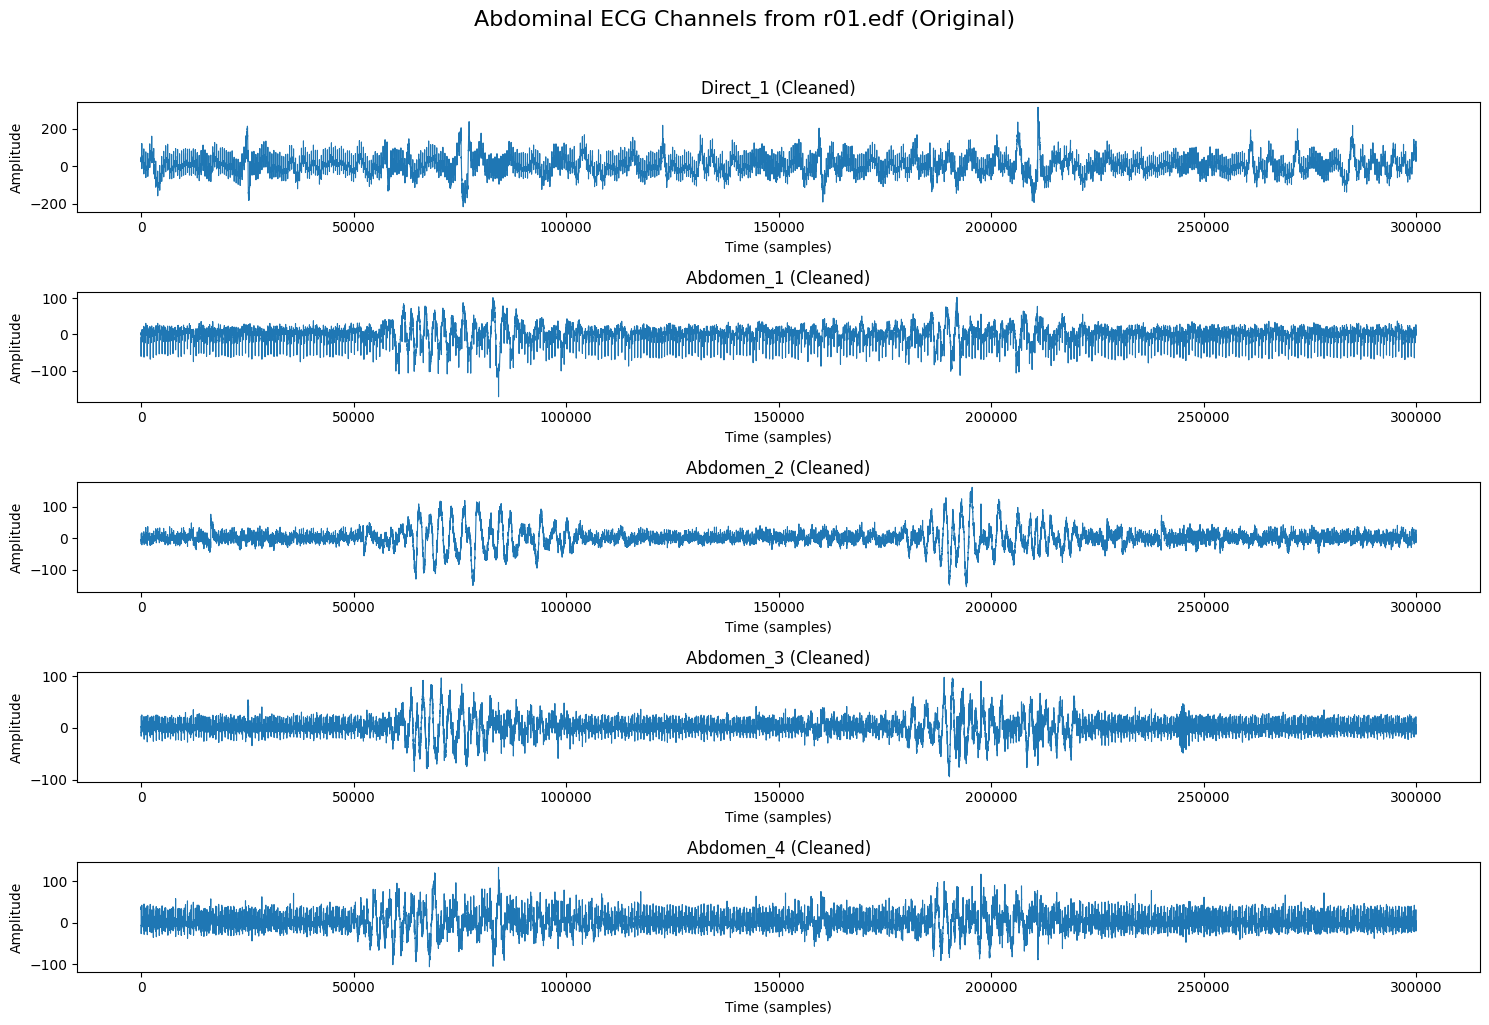

In [77]:
import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

# Load EDF file
edf_path = "../data/raw/r01.edf"
edf = pyedflib.EdfReader(edf_path)

# Get metadata
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
signal_freq = edf.getSampleFrequency(0)  # Assume all channels have same sampling freq

print("Channels:", channel_labels)
print("Sampling frequency:", signal_freq)

# Read signals into a DataFrame
signals = [edf.readSignal(i) for i in range(n_channels)]
df = pd.DataFrame({label: signal for label, signal in zip(channel_labels, signals)})

edf._close()
del edf

# Select only abdominal ECG channels
abdomen_channels = ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']

# Plot abdominal signals (cleaned)
plt.figure(figsize=(15, 10))

for i, channel in enumerate(abdomen_channels):
    cleaned = nk.ecg_clean(df[channel], sampling_rate=signal_freq)
    plt.subplot(5, 1, i + 1)
    plt.plot(df[channel], linewidth=0.8) # try also with cleaned
    plt.title(f"{channel} (Cleaned)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

plt.suptitle("Abdominal ECG Channels from r01.edf (Original)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [78]:
raw_signal = df['Abdomen_1'].values
qrs_epochs = nk.ecg_segment(raw_signal, rpeaks=None, sampling_rate=1000, show=False)

A = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in qrs_epochs.items()
}).T  # Transpose to shape (n_beats, n_samples)

print("(#beats, #samples) =", A.shape)

(#beats, #samples) = (414, 725)


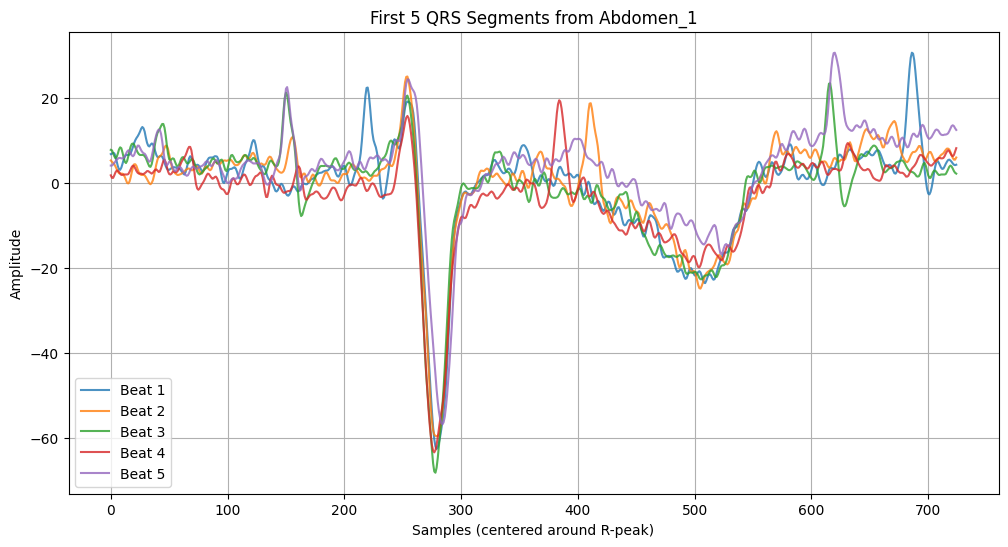

In [79]:
import matplotlib.pyplot as plt

# Plot first 5 QRS segments
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.plot(A.iloc[i], label=f'Beat {i+1}', alpha=0.8)

plt.title("First 5 QRS Segments from Abdomen_1")
plt.xlabel("Samples (centered around R-peak)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [80]:
import numpy as np

# If A is a pandas DataFrame:
if A.isna().any().any() or np.isinf(A.values).any():
    A = A.fillna(0)
    A = A.replace([np.inf, -np.inf], 0)
    A = A.values  # Convert to NumPy array before SVD
else:
    A = A.values  # Make sure A is a NumPy array for SVD


In [81]:
import numpy as np
    
# Perform Singular Value Decomposition on A
U, S, VT = np.linalg.svd(A, full_matrices=False)

# Extract the dominant maternal component (rank-1 approximation)
A_M = np.outer(U[:, 0], VT[0, :]) * S[0]

# Compute the residual matrix (A_R) by subtracting maternal component from A
A_residual = A - A_M


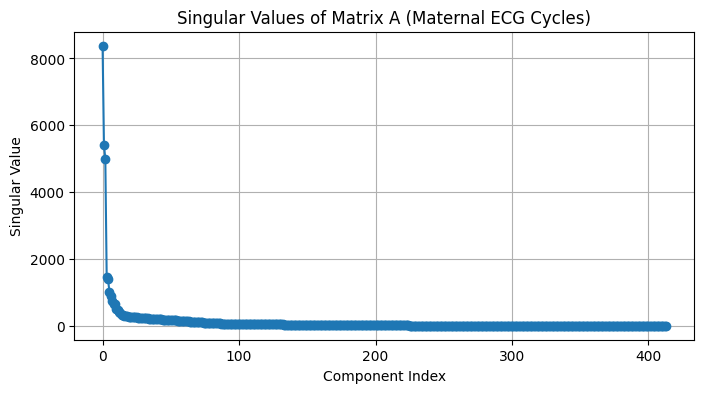

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(S, marker='o')
plt.title("Singular Values of Matrix A (Maternal ECG Cycles)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()


In [83]:
residual_signal = A_residual.flatten()

fetal_qrs_epochs = nk.ecg_segment(residual_signal, rpeaks=None, sampling_rate=1000, show=False)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

# Perform SVD
U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)

# Dominant fetal ECG component (rank-1 approximation)
B_F = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]

B_residual = B - B_F

c:\Users\Ester\Desktop\ecg-svd\.venv\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\Ester\Desktop\ecg-svd\.venv\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


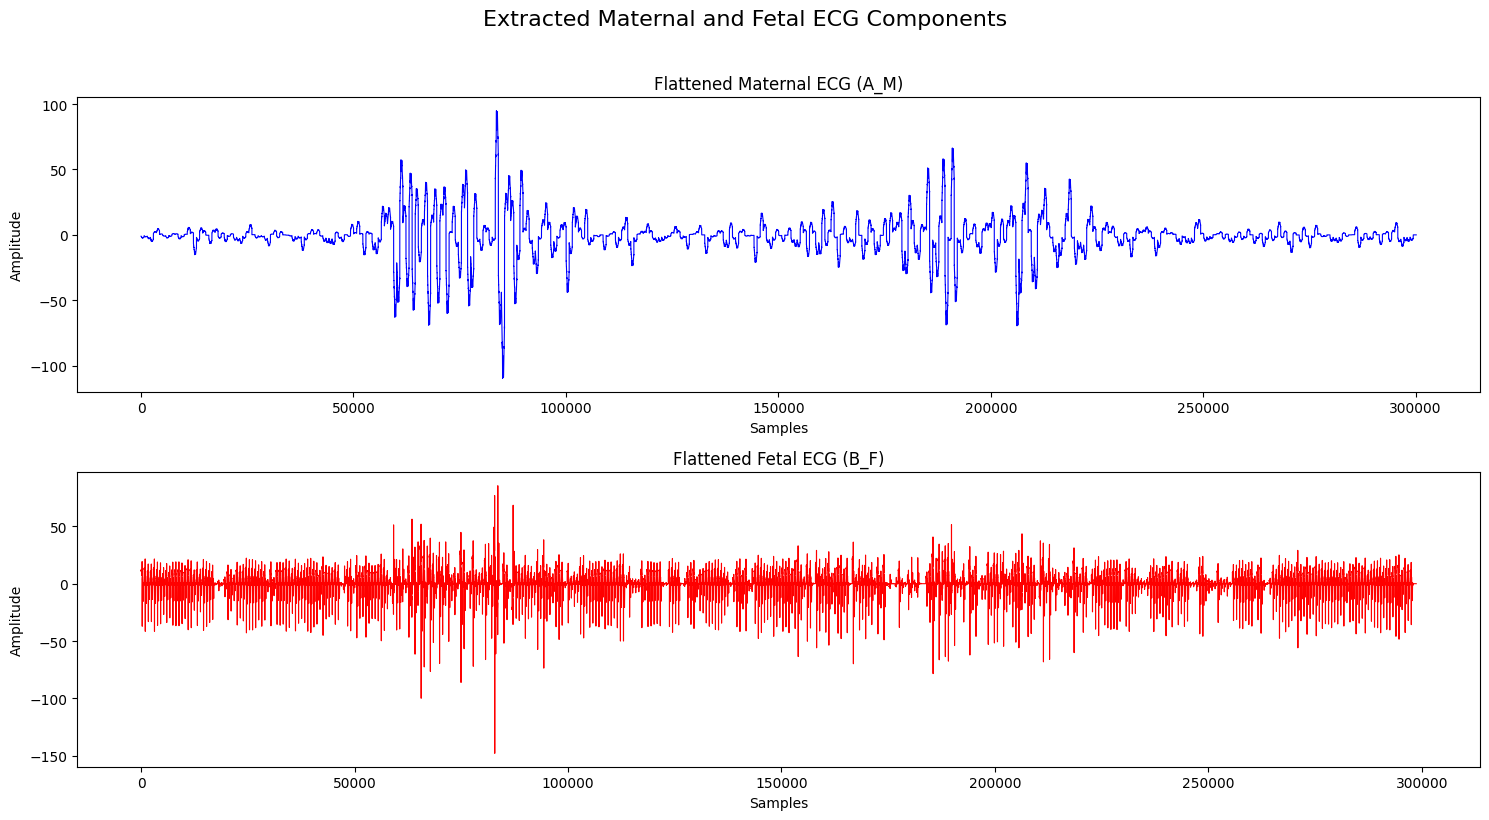

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten maternal ECG cycles into one continuous signal
mecg_flat = A_M.flatten()

# Flatten fetal ECG cycles into one continuous signal
fecg_flat = B_F.flatten()

# Plot flattened Maternal and Fetal ECG signals with consistent layout
plt.figure(figsize=(15, 8))

# Flattened Maternal ECG
plt.subplot(2, 1, 1)
plt.plot(mecg_flat, color='blue', linewidth=0.8)
plt.title("Flattened Maternal ECG (A_M)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Flattened Fetal ECG
plt.subplot(2, 1, 2)
plt.plot(fecg_flat, color='red', linewidth=0.8)
plt.title("Flattened Fetal ECG (B_F)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.suptitle("Extracted Maternal and Fetal ECG Components", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


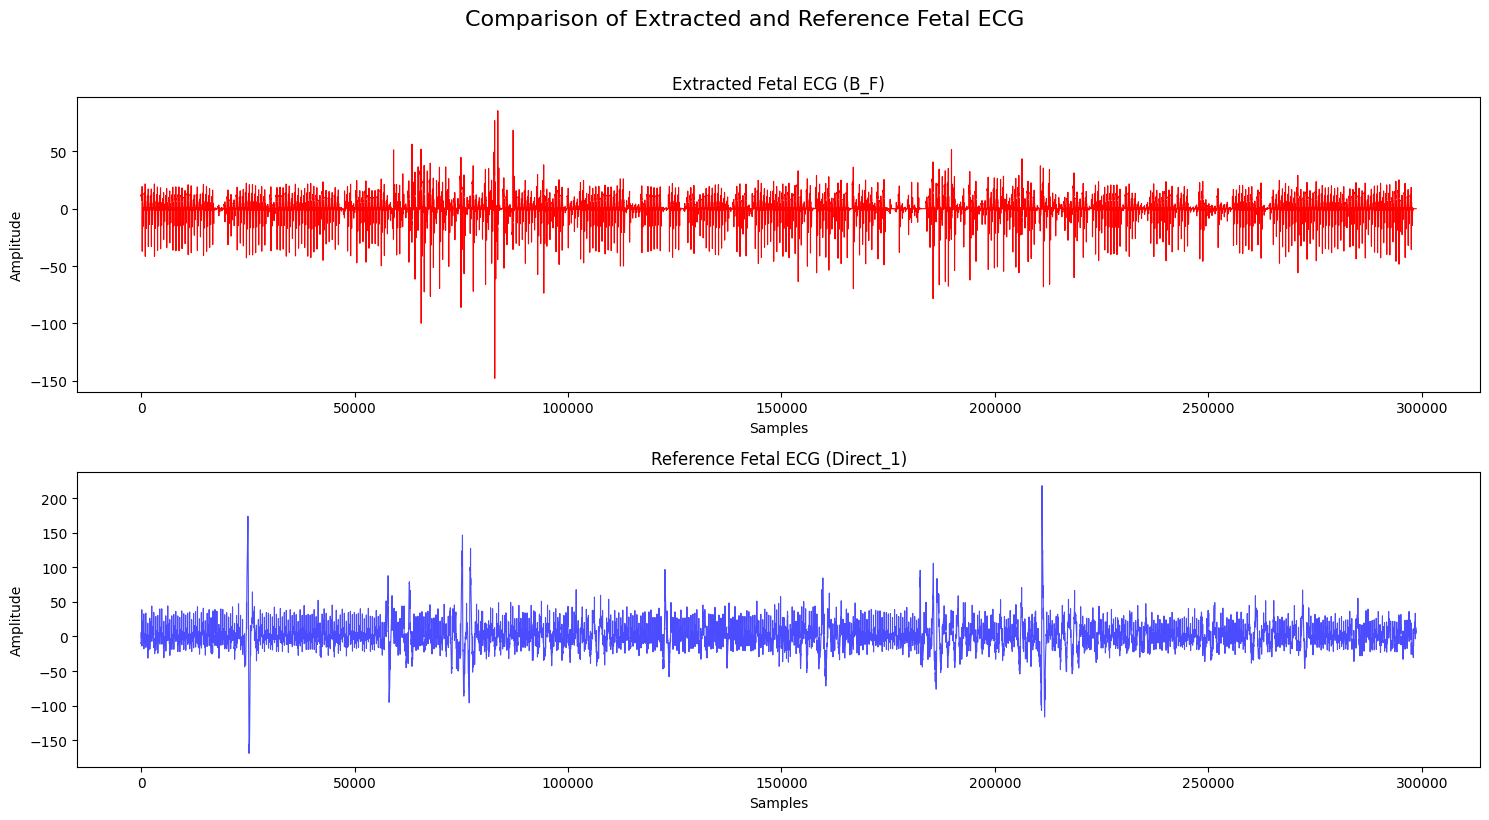

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten extracted fetal ECG cycles
fecg_flat = B_F.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_cleaned = nk.ecg_clean(direct1_signal, sampling_rate=signal_freq)
direct1_segment = direct1_cleaned[:len(fecg_flat)]

# Consistent layout with previous figures
plt.figure(figsize=(15, 8))

# Plot Extracted Fetal ECG
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, color='red', linewidth=0.8)
plt.title("Extracted Fetal ECG (B_F)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, color='blue', alpha=0.7, linewidth=0.8)
plt.title("Reference Fetal ECG (Direct_1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.suptitle("Comparison of Extracted and Reference Fetal ECG", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [86]:
residual_signal = B_residual.flatten()

fetal_qrs_epochs = nk.ecg_segment(residual_signal, rpeaks=None, sampling_rate=1000, show=False)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

# Perform SVD
U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)

# Dominant fetal ECG component (rank-1 approximation)
B_F2 = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]

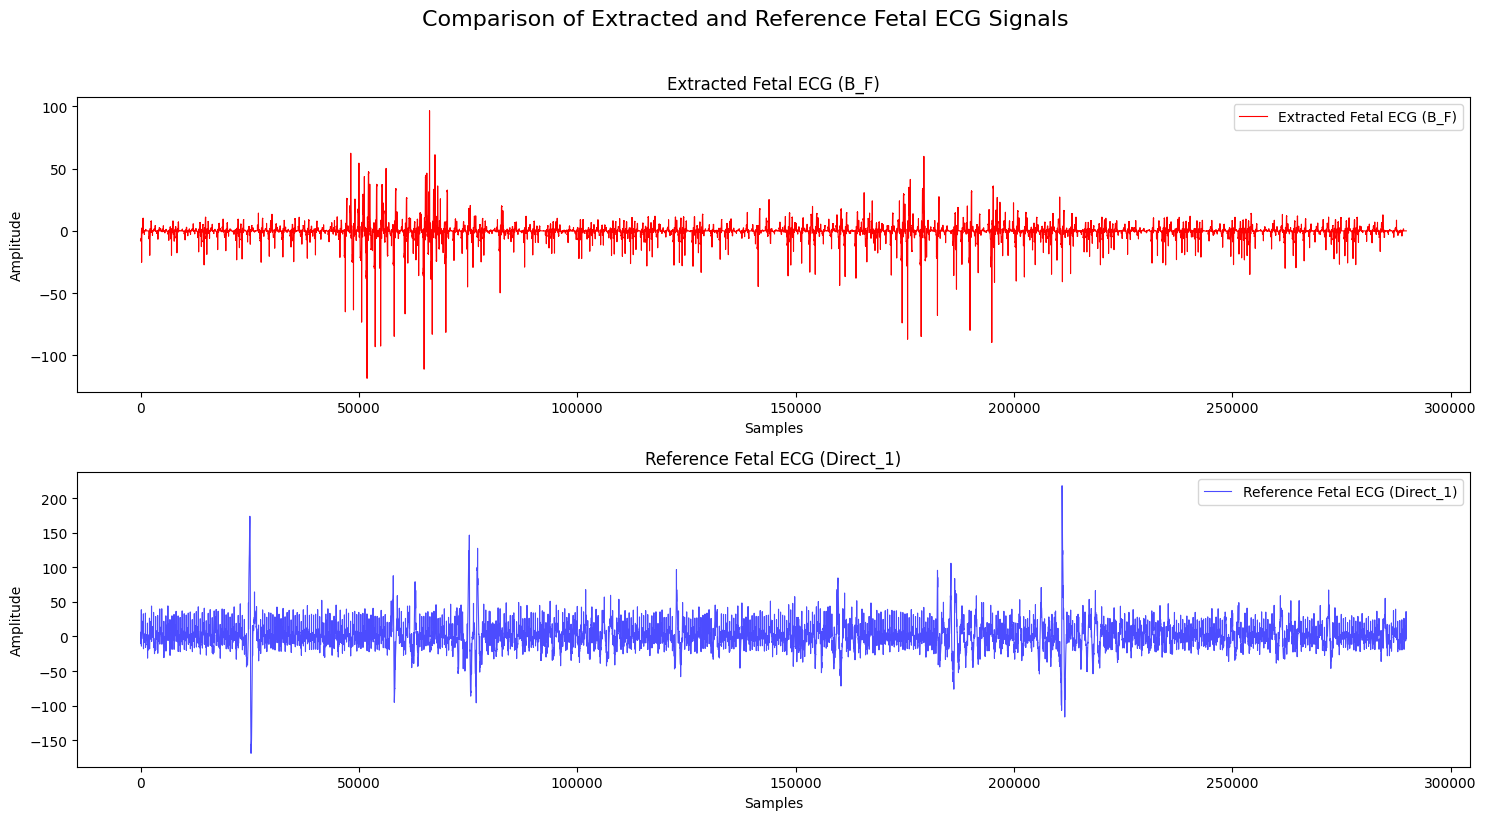

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten extracted fetal ECG cycles
fecg_flat = B_F2.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_cleaned = nk.ecg_clean(direct1_signal, sampling_rate=signal_freq)
direct1_segment = direct1_cleaned[:len(fecg_flat)]

plt.figure(figsize=(15, 8))

# Extracted Fetal ECG (B_F)
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, label='Extracted Fetal ECG (B_F)', color='red', linewidth=0.8)
plt.title('Extracted Fetal ECG (B_F)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

# Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, label='Reference Fetal ECG (Direct_1)', color='blue', alpha=0.7, linewidth=0.8)
plt.title('Reference Fetal ECG (Direct_1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.suptitle("Comparison of Extracted and Reference Fetal ECG Signals", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()